# Generating datasets with Cell-APP in Jupyter

This notebook is a minimal guide to creating cell segmentation model-training datasets with Cell-APP.

In [1]:
#required imports 
import numpy as np
import torch
import torchvision
import cell_AAP.annotation.annotation_utils as au
import cell_AAP.annotation.annotator as ann
import cell_AAP.annotation.dataset_write as dw
import cell_AAP.configs as cfg
from cell_AAP.napari_dataset.simple_coco_convert import write_coco_json


#optional imports
import seaborn as sns
import tifffile as tiff
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#for classification
import hdbscan
import umap

/home/anishjv/.local/lib/python3.11/site-packages/cell_AAP/annotation/annotation_utils.py:27: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  tophatstruct: Optional[any] = square(71),
/home/anishjv/.local/lib/python3.11/site-packages/cell_AAP/annotation/annotation_utils.py:108: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  tophatstruct: Optional[any] = square(71),
/home/anishjv/.local/lib/python3.11/site-packages/cell_AAP/defaults.py:10: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  _HELA["TOPHATSTRUCT"] = skimage.morphology.square(71)
/sw/pkgs/arc/mamba/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See 

Here we **load a $\mu$SAM model**. The specific model I initialize was downloaded from: https://zenodo.org/records/11111177. For a comprehensive menu of available models see: https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#choosing-a-model

In [2]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.modeling import Sam

sam_checkpoint = "vit_l.pt"
model_type = "vit_l"
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device = device)
predictor = SamPredictor(sam)

/home/anishjv/.local/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Here we **organize my input images** into 4 categories: training_tl, training_fluoro, testing_tl, testing_fluoro. Images categorized as training will be used to train a cell segmentation model; images categorized as testing will be used to test that same model. 

In [11]:
paths = [  
    '/home/anishjv/cell_seg_classify/notebooks/tutorials/dataset_generation/20250429-cellapp-data',
]

fluoro_files = []
phs_files = []
for path in paths:
    fluoro_files += glob.glob(path+'/*Texas Red'+ '*')
    phs_files += glob.glob(path+'/*phs' + '*')

#arbitrary method to sort between training and testing images; you may implement your own
training_tl = sorted([file for file in phs_files if 's12' not in file]) 
testing_tl = sorted([file for file in phs_files if 's12' in file])

training_fluoro = sorted([file for file in fluoro_files if 's12' not in file])
testing_fluoro = sorted([file for file in fluoro_files if 's12' in file])

#here I combine the training and testing datasets for convinience, making sure to preserve order

tl = training_tl + testing_tl
fluoro = training_fluoro + testing_fluoro

Here we **generate the dataset**. This requires three steps:

1. Instantiate an instance of the `Cfg` class and call the class method `get_config`. This tells Cell-APP to use standard configurations (optimized for HeLa cells—transmitted light—and their nuclei—fluorescence).

2. Instantiate an instance of the `Annotator` class and call the class method `get`. The method takes 3 arguments:  
   - `configs`: an instance of the Cfg class  
   - `dna_image_list`: list of fluorescence microscopy images  
   - `phase_image_list`: list of transmitted light microscopy images
   
      <!-- blank line -->
     
3. Call the methods `crop` and `gen_df` on the instance you instantiated in the last step.

In [12]:
%time
#step 1
configs = cfg.Cfg.get_config()

#ff you want to change a configuration, you can do so like this: 
configs.iou_thresh = 0.5

#step 2
instance_whole = ann.Annotator.get(configs, fluoro ,tl)

#step 3
'''
Here I define the function 'sd_intensity()' and pass it to 'gen_df()'. This is entirely optional, and only relevant if you plan to 
classify the cells in your dataset. The argument 'extra_props' of 'gen_df()' exists to allow users to extract custom properties from 
their fluoresence images that may aid downstream classification. If you have no custom properties to define, set 'extra_props = ()'
'''
def sd_intensity(regionmask, intensity_image):
        return np.std(intensity_image[regionmask])


df_whole = instance_whole.crop(predictor = predictor).gen_df(extra_props = (sd_intensity,))

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs
(3, 2048, 2048)
Image 1/3: found 175 candidate cells
Image 1/3: current box size is  78.0 pixels
Image 1/3: kept 133 cells
Image 2/3: found 266 candidate cells
Image 2/3: current box size is  76.0 pixels
Image 2/3: kept 238 cells
Image 3/3: found 229 candidate cells
Image 3/3: current box size is  80.0 pixels
Image 3/3: kept 200 cells


Here we will **visualize the results**.

In [13]:
#These are just helper functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.2])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))

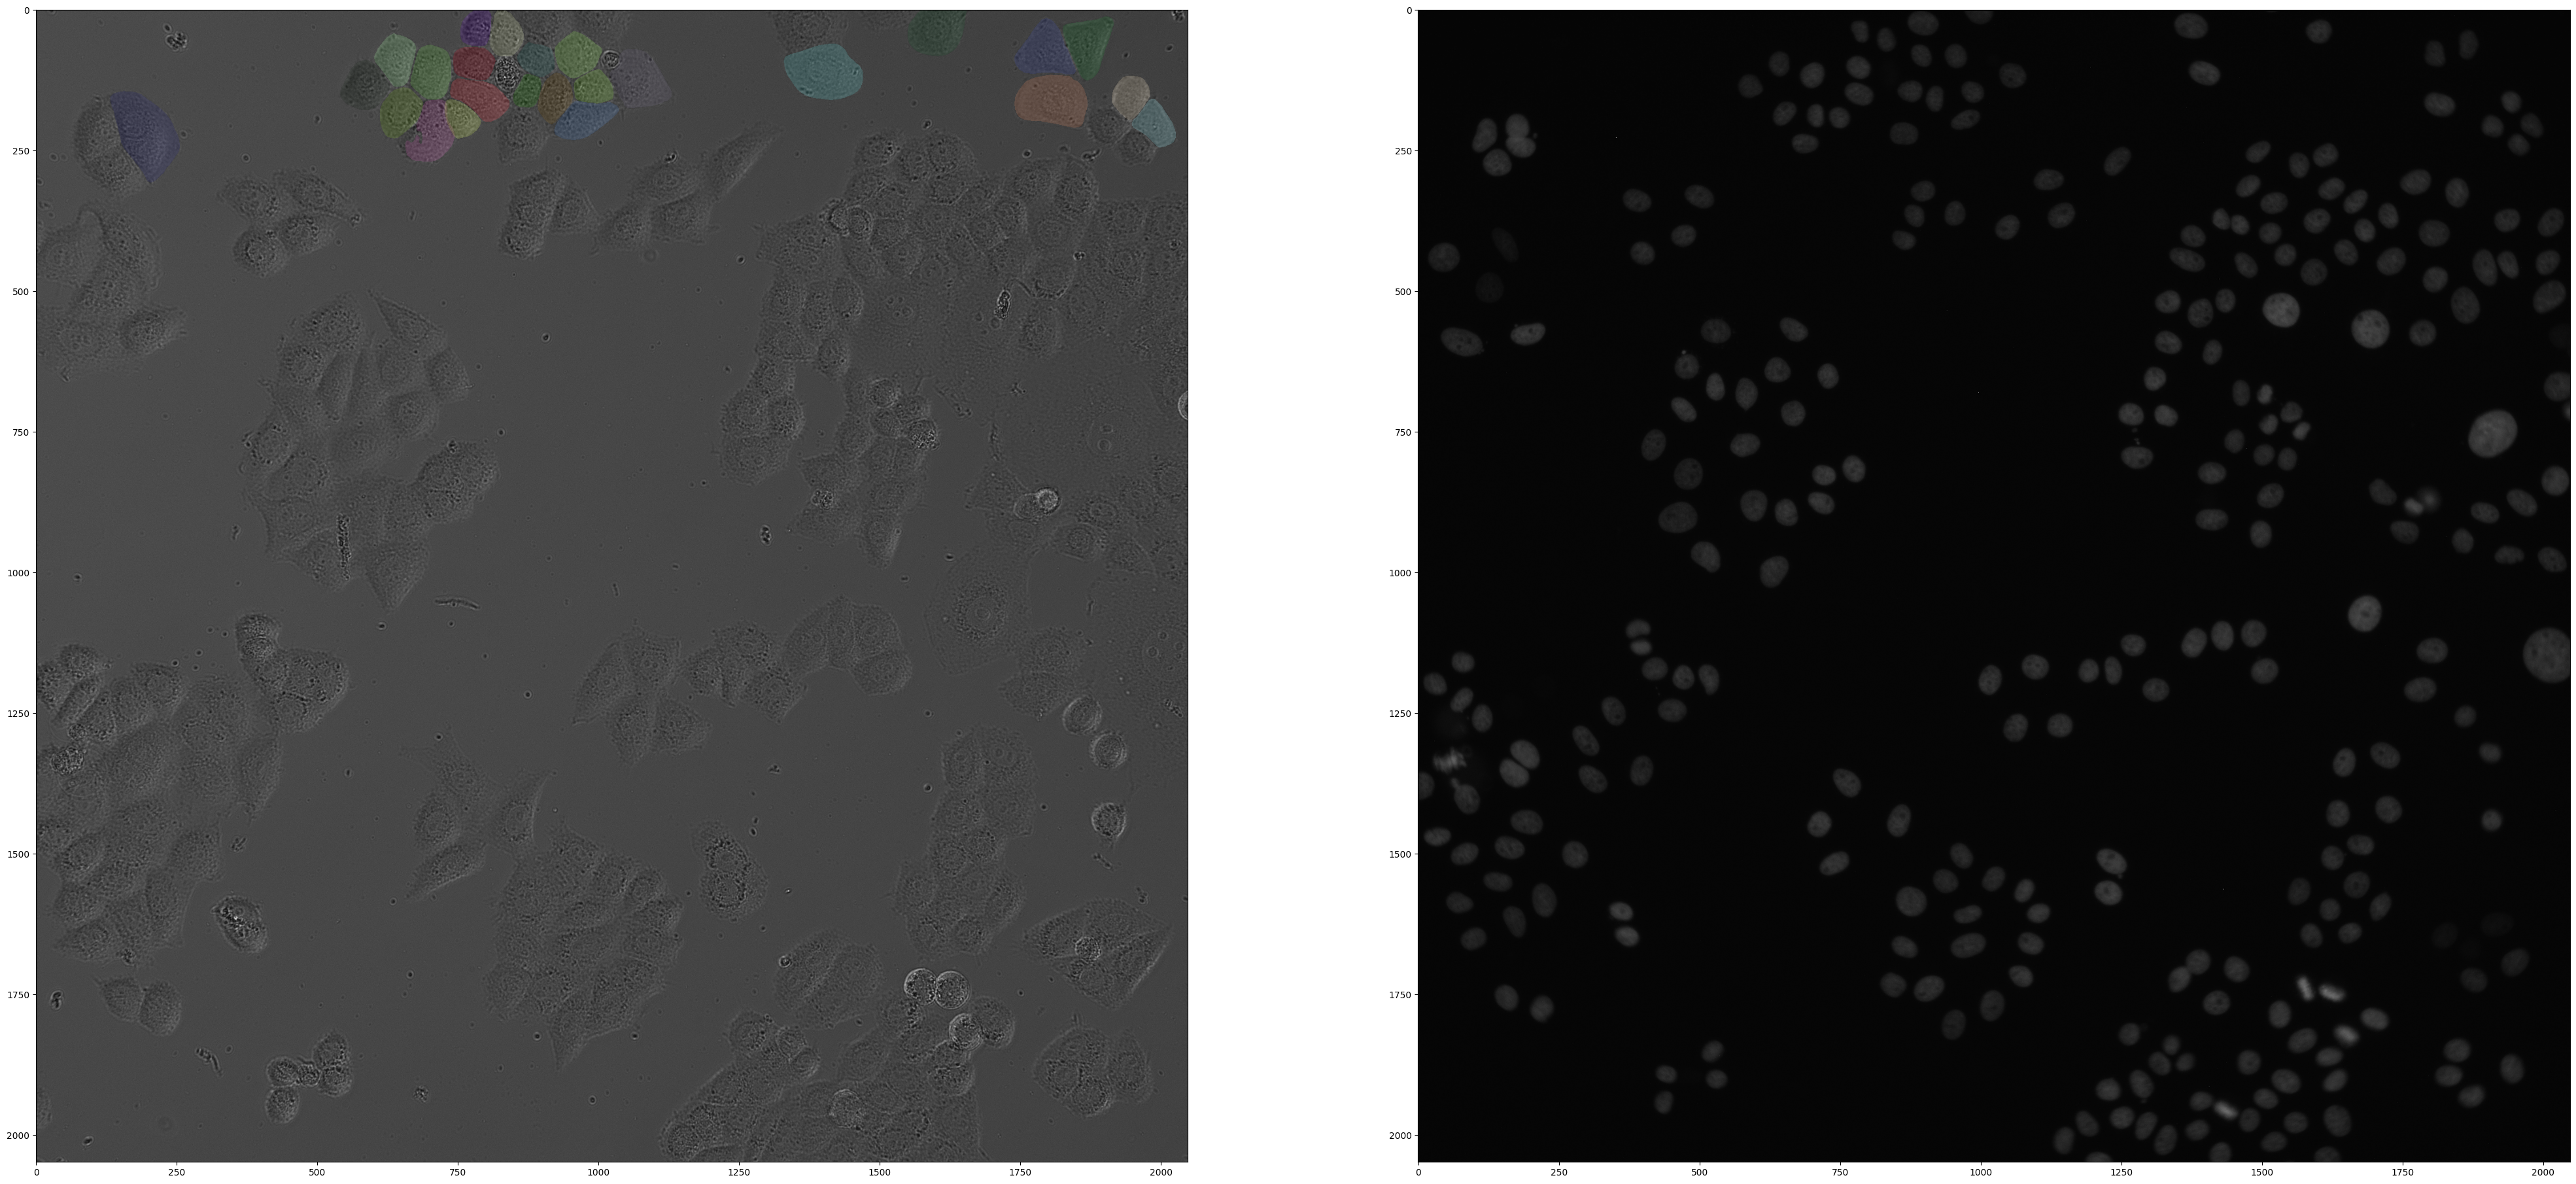

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (50,50))

#select the image you want to see (index in tl)
img_indx = 1
#select how many segmentations you want to see (visuzalizing all segmentations may crash your device)
num_segs_to_show = 25

ax[0].imshow(au.bw_to_rgb(instance_whole.phase_image_stack[img_indx]))
ax[1].imshow(au.bw_to_rgb(instance_whole.dna_image_stack[img_indx]))
for i in range(num_segs_to_show):
    mask = np.unpackbits(instance_whole.segmentations[img_indx][i], axis = 0, count = instance_whole.phase_image_stack[img_indx].shape[0])
    mask = np.array([mask]).astype('uint8')
    show_mask(mask, ax[0], random_color = True)

plt.show()

Here we **assemble the dataset**. This will require you to: 

1. Define the range of images comprising your training, testing, and optionally validation datasets. You should define these ranges as non-overlapping tuples and store them in a list. For example, below I create the list 'splits,' which contains tuples defining my training and tetsing datasets.

2. Call `dw.write_dataset_ranges()`

In [15]:
tl_image_stack = instance_whole.phase_image_stack
segmentations = instance_whole.segmentations

print(f'There should be {len(training_tl)} images in the training dataset, and {len(testing_tl)} images in the testing dataset') 

splits = [
    (0, len(training_tl)-1),
    (len(training_tl), len(tl)-1)
]

print(f'The defined splits are: training = {splits[0]}, testing = {splits[1]}')

'''
We must 'buffer' the dataset because we have forgone classification. 'write_dataset_ranges' expects the last column of the dataset to
be a classification for each cells, we will just append a column of 0s. 
'''
copy = df_whole.copy()
classification_buffer = np.zeros((df_whole.shape[0],1))
df_whole_buffered = np.hstack(
    (copy, classification_buffer)
)
df_whole_buffered.shape

save_path = '/home/anishjv/cell_seg_classify/datasets'
name = 'generic_dataset_name'
dw.write_dataset_ranges(
    save_path, #tell Cell-APP where to save your dataset
    tl_image_stack, #stack of transmitted light images
    segmentations, #segmentations
    df_whole_buffered, #dataset generated by Annotator.crop().gen_df()
    splits, 
    name, #tell Cell-APP what you'd like your dataset to be called
    {0: 'cell'} #inform Cell-APP on the types of instances your dataset contains; if there were more categories: {0: 'cat_1', 1: 'cat_2'}
)

There should be 2 images in the training dataset, and 1 images in the testing dataset
The defined splits are: training = (0, 1), testing = (2, 2)
Unique label IDs in data: [0]
label_to_class mapping: {0: 'cell'}
Number of cells with label_id -1: 0
before binning (2048, 2048, 3)
after binning (1024, 1024, 3)
before binning (2048, 2048, 3)
after binning (1024, 1024, 3)
before binning (2048, 2048, 3)
after binning (1024, 1024, 3)


In [16]:
#here I use the names '0' and '1;' Cell-APP defaults to naming your splits by their index
for split, split_name in zip(splits, ['0', '1']):
    
    split_dir = os.path.join(save_path, name, split_name)
    
    write_coco_json(
        images_dir=os.path.join(split_dir, 'images'),
        annotations_dir=os.path.join(split_dir, 'annotations'),
        out_json=os.path.join(split_dir, f"{name}_{split_name}.json"),
        categories=[{'id': 0, 'name': 'cell'}], #if there were more categories [{'id': 0, 'name': 'cat_0'}, {'id': 1, 'name': 'cat_1'}]
        dataset_info={"description": name, "version": "1.0", "split": split_name}
    )

COCO convert: images_dir=/home/anishjv/cell_seg_classify/datasets/generic_dataset_name/0/images
COCO convert: annotations_dir=/home/anishjv/cell_seg_classify/datasets/generic_dataset_name/0/annotations
COCO convert: out_json=/home/anishjv/cell_seg_classify/datasets/generic_dataset_name/0/generic_dataset_name_0.json
COCO convert: categories=['cell']
Processing image_id=1: 5.jpg size=(1024, 1024)
  Found 83 masks for image_id=1
  Mask file: 5_cell_frame5cell18.png
    mask shape=(1024, 1024) dtype=uint8 nnz=1644
    Added annotation_id=1
  Mask file: 5_cell_frame5cell40.png
    mask shape=(1024, 1024) dtype=uint8 nnz=1439
    Added annotation_id=2
  Mask file: 5_cell_frame5cell26.png
    mask shape=(1024, 1024) dtype=uint8 nnz=2009
    Added annotation_id=3
  Mask file: 5_cell_frame5cell30.png
    mask shape=(1024, 1024) dtype=uint8 nnz=1186
    Added annotation_id=4
  Mask file: 5_cell_frame5cell20.png
    mask shape=(1024, 1024) dtype=uint8 nnz=1290
    Added annotation_id=5
  Mask fil

# Classification (Optional)

Here we will show you how to classify cells in your dataset using  properties Cell-APP extracts from your fluoresence image inputs. 

The toy dataset we created above is too small for successfull classification, so for demonstration purposes, we'll load in a pre-created dataset. 

In [14]:
#loading in the pre-created dataset
df_saved = np.load('embeddings/hela.npy')[:, 0:-1]

Here we **project our dataset** using the Uniform Manifold Approximation and Projection algorithm (UMAP). For more information on UMAP see: https://umap-learn.readthedocs.io/en/latest/.

In [15]:
df_mapper = umap.UMAP(n_neighbors=75,
                   min_dist=0,
                   n_components=2,
                   random_state=42,).fit(df_saved)

df_embedding = df_mapper.transform(df_saved)

/home/anishjv/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Here we **find clusters** using the HDBSCAN algorithm. For more information on HDBSCAN, see: https://app.readthedocs.org/projects/hdbscan/downloads/pdf/stable/.

In [24]:
labels_whole_embedding = hdbscan.HDBSCAN(min_samples=50,
                                        min_cluster_size = 1000,
                                        ).fit_predict(df_embedding)

#This code appends a column of classifications (one per cell; one row is data on one cell) to our dataframe
df_saved_labeled = au.add_labels(df_saved, labels_whole_embedding)

/home/anishjv/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anishjv/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Here we will **visualize** our projection and clustering.

(3711, 2)
(2125, 2)
(55177, 2)
(9, 2)


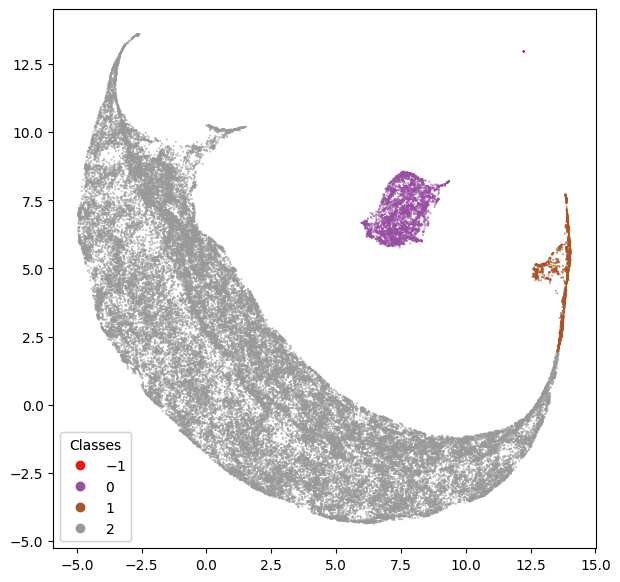

In [25]:
fig, ax = plt.subplots(1, figsize=(7,7))
scatter = ax.scatter(
    df_embedding[:, 0], 
    df_embedding[:, 1], 
    c=df_saved_labeled[:, -1], 
    s=0.1, 
    cmap = 'Set1', 
    label=df_saved_labeled[:, -1]
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="lower left", 
    title="Classes"
)

ax.add_artist(legend1)

#this piece of code creates data structures that store cell-identififers for cells belonging to each found cluster.
clusters = au.write_clusters(df_saved_labeled, -1)
for cluster in clusters.values():
    print(cluster.shape)

We know from working with this dataset that cluster 0 contains mitotic cells, cluster 1 contains interphase and dead cells, and cluster 2 contains interphase cells. If we had generated this dataset in this tutorial, we could display cells from each cluster using the code below. In practice, this kind of visualization is how you would verify that your classification worked. 

In [ ]:
fig, ax = plt.subplots(ncols = 10, figsize = (30,20))

clus_num = 0
for i in range(10):
    j = i 
    ax[i].imshow(instance_whole.roi[int(clusters[clus_num][j, 0])][int(clusters[clus_num][j, 1])], cmap = 'rocket')
    ax[i].set_xlabel(f'Frame {clusters[clus_num][j, 0]} Cell {clusters[clus_num][j, 1]}')

plt.tight_layout()
plt.show()

After classification, you can save your dataset just as we did above. The only differences are: 

1. No need to buffer the dataset, we have already added the column of classes `df_saved_labeled = au.add_labels(df_saved, labels_whole_embedding)`
2. You should tell Cell-APP to expect multiple classes (dict keys should match the cluster numbers) in `dw.write_dataset_ranges()'
3. Similarly modify the argument `categories` in `write_coco_json()`